In [143]:
import numpy as np
import scipy.integrate
import copy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import winsound as ws
import cProfile

## unit for each parameter is commented after it is declared (inline)
## if the suggested value for the parameter is different -
## The original default value from the original ADM1 report by Batstone et al (2002), is commented after each unit (inline)

# reading influent and initial condition data from csv files
influent_state_temp = pd.read_csv("digester_influent.csv") #this drastically decreases processing time
influent_state  = influent_state_temp.to_dict()

initial_state = pd.read_csv("digester_initial.csv")

# Stoichiometric parameter
Stoichiometric_parameters_temp = pd.read_csv("Definitions.csv", skiprows = [0,1,2], index_col = 0, usecols = [0,1], float_precision='round_trip') #read all stoichiometric parameters as acuratly as available
Stoichiometric_parameters = Stoichiometric_parameters_temp.value.to_dict() #this drastically decreases processing time


pH = 7.4655377 # initial pH
T_op =  308.15 #k
# Physical parameter values used in BSM2 from the Rosen et al (2006) BSM2 report

#testing volume for experiment
T_ad =  308.15 #K
V_liq =  3400 #m^3
V_gas =  300 #m^3
p_atm =  1.013 #bar
q_ad =  178.4674 #m^3.d^-1 initial flow rate (can be modified during the simulation by the control algorithm)

V_ad = V_liq + V_gas #m^-3

##constant definition from the Rosen et al (2006) BSM2 report
R =  0.083145 #bar.M^-1.K^-1
T_base =  298.15 #K

# Physico-chemical parameter values from the Rosen et al (2006) BSM2 report
K_a_va =  10 ** -4.86 #M  ADM1 value = 1.38 * 10 ^ -5
K_a_bu =  10 ** -4.82 #M #1.5 * 10 ^ -5
K_a_pro =  10 ** -4.88 #M #1.32 * 10 ^ -5
K_a_ac =  10 ** -4.76 #M #1.74 * 10 ^ -5
K_a_H2S = 10 ** -7.04 #M from pubchem
k_A_B_va =  10 ** 10 #M^-1 * d^-1
k_A_B_bu =  10 ** 10 #M^-1 * d^-1
k_A_B_pro =  10 ** 10 #M^-1 * d^-1
k_A_B_ac =  10 ** 10 #M^-1 * d^-1
k_A_B_co2 =  10 ** 10 #M^-1 * d^-1
k_A_B_IN =  10 ** 10 #M^-1 * d^-1
k_A_B_H2S = 10 ** 10 #M^-1 * d^-1 assumed based on above figures
k_p = 5 * 10 ** 4 #m^3.d^-1.bar^-1 #only for BSM2 AD conditions, recalibrate for other AD cases #gas outlet friction
k_L_a =  200.0 #d^-1

S_nh4_ion = 0.0041 #kmole N.m^-3 the initial value is from Rosen et al (2006) BSM2 report and it is calculated further down and does not need to be initiated
S_co2 = 0.14 #kmole C.m^-3 the initial value is from Rosen et al (2006) BSM2 report and it is calculated further down and does not need to be initiated

K_w =  10 ** -14.0 * np.exp((55900 / (100 * R)) * (1 / T_base - 1 / T_ad)) #M #2.08 * 10 ^ -14
K_a_co2 =  10 ** -6.35 * np.exp((7646 / (100 * R)) * (1 / T_base - 1 / T_ad)) #M #4.94 * 10 ^ -7
K_a_IN =  10 ** -9.25 * np.exp((51965 / (100 * R)) * (1 / T_base - 1 / T_ad)) #M #1.11 * 10 ^ -9
p_gas_h2o =  0.0313 * np.exp(5290 * (1 / T_base - 1 / T_ad)) #bar #0.0557
K_H_co2 =  0.035 * np.exp((-19410 / (100 * R))* (1 / T_base - 1 / T_ad)) #Mliq.bar^-1 #0.0271
K_H_ch4 =  0.0014 * np.exp((-14240 / (100 * R)) * (1 / T_base - 1 / T_ad)) #Mliq.bar^-1 #0.00116
K_H_h2 =  7.8 * 10 ** -4 * np.exp(-4180 / (100 * R) * (1 / T_base - 1 / T_ad)) #Mliq.bar^-1 #7.38*10^-4

####this needs a propper function, but doesn't have one yet, for use H2 has been copied
K_H_H2S = 7.8 * 10 ** -4 * np.exp(-4180 / (100 * R) * (1 / T_base - 1 / T_ad)) #Mliq.bar^-1
#####

K_pH_aa =  (10 ** (-1 * (Stoichiometric_parameters['pH_LL_aa'] + Stoichiometric_parameters['pH_UL_aa']) / 2.0))
nN_aa =  (3.0 / (Stoichiometric_parameters['pH_UL_aa'] - Stoichiometric_parameters['pH_LL_aa'])) #we need a differece between 'N_aa' and 'N_aa' to avoid typos and nN_aa' refers to the 'N_aa' in BSM2 report
K_pH_ac = (10 ** (-1 * (Stoichiometric_parameters['pH_LL_ac'] + Stoichiometric_parameters['pH_UL_ac']) / 2.0))
n_ac =  (3.0 / (Stoichiometric_parameters['pH_UL_ac'] - Stoichiometric_parameters['pH_LL_ac']))
K_pH_h2 =  (10 ** (-1 * (Stoichiometric_parameters['pH_LL_h2'] + Stoichiometric_parameters['pH_UL_h2']) / 2.0))
n_h2 =  (3.0 / (Stoichiometric_parameters['pH_UL_h2'] - Stoichiometric_parameters['pH_LL_h2']))
n_hSRB  = 3.0 / (Stoichiometric_parameters['pH_UL_hSRB'] - Stoichiometric_parameters['pH_LL_hSRB'])
pH_Lim_hSRB = 10 **(-(Stoichiometric_parameters['pH_UL_hSRB'] + Stoichiometric_parameters['pH_LL_hSRB']) / 2.0)

In [144]:
# Function to set influent values for influent state variables at each simulation step
def setInfluent(i):
    global S_su_in, S_aa_in, S_fa_in, S_va_in, S_bu_in, S_pro_in, S_ac_in, S_h2_in,S_ch4_in, S_IC_in, S_IN_in, S_I_in, S_IS_in, S_SO4_in, X_xc_in, X_ch_in,X_pr_in,X_li_in,X_su_in,X_aa_in,X_fa_in,X_c4_in,X_pro_in,X_ac_in,X_h2_in,X_I_in,X_hSRB_in, S_cation_in,S_anion_in
    ##variable definition
    # Input values (influent/feed)
    S_su_in = influent_state['S_su'][i] #kg COD.m^-3
    S_aa_in = influent_state['S_aa'][i] #kg COD.m^-3
    S_fa_in = influent_state['S_fa'][i] #kg COD.m^-3
    S_va_in = influent_state['S_va'][i] #kg COD.m^-3
    S_bu_in = influent_state['S_bu'][i] #kg COD.m^-3
    S_pro_in = influent_state['S_pro'][i] #kg COD.m^-3
    S_ac_in = influent_state['S_ac'][i] #kg COD.m^-3
    S_h2_in = influent_state['S_h2'][i] #kg COD.m^-3
    S_ch4_in = influent_state['S_ch4'][i]  #kg COD.m^-3
    S_IC_in = influent_state['S_IC'][i] #kmole C.m^-3
    S_IN_in = influent_state['S_IN'][i] #kmole N.m^-3
    S_I_in = influent_state['S_I'][i] #kg COD.m^-3
    S_IS_in = influent_state['S_IS'][i] #kg COD.m^-3
    S_SO4_in = influent_state['S_SO4'][i] #kg COD.m^-3
    
    X_xc_in = influent_state['X_xc'][i] #kg COD.m^-3
    X_ch_in = influent_state['X_ch'][i] #kg COD.m^-3
    X_pr_in = influent_state['X_pr'][i] #kg COD.m^-3
    X_li_in = influent_state['X_li'][i] #kg COD.m^-3
    X_su_in = influent_state['X_su'][i] #kg COD.m^-3
    X_aa_in = influent_state['X_aa'][i] #kg COD.m^-3
    X_fa_in = influent_state['X_fa'][i] #kg COD.m^-3
    X_c4_in = influent_state['X_c4'][i] #kg COD.m^-3
    X_pro_in = influent_state['X_pro'][i] #kg COD.m^-3
    X_ac_in = influent_state['X_ac'][i] #kg COD.m^-3
    X_h2_in = influent_state['X_h2'][i] #kg COD.m^-3
    X_I_in = influent_state['X_I'][i] #kg COD.m^-3
    X_hSRB_in = influent_state['X_hSRB'][i] #kg COD.m^-3
    
    S_cation_in = influent_state['S_cation'][i] #kmole.m^-3
    S_anion_in = influent_state['S_anion'][i] #kmole.m^-3

In [145]:
def set_initial_states():
    # initiate variables (initial values for the reactor state at the initial time (t0)             
    return initial_state.iloc[0,:] 

In [146]:
# Function for calulating the derivatives related to ADM1 system of equations from the Rosen et al (2006) BSM2 report
def ADM1_ODE(t, state_zero):
    #global S_nh4_ion, S_co2, p_gas, q_gas, q_ch4
    S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S = state_zero

    S_nh4_ion =  (S_IN - S_nh3)
    S_co2 =  (S_IC - S_hco3_ion)
    I_pH_aa =  ((K_pH_aa ** nN_aa) / (S_H_ion ** nN_aa + K_pH_aa ** nN_aa))
    I_pH_ac =  ((K_pH_ac ** n_ac) / (S_H_ion ** n_ac + K_pH_ac ** n_ac))
    I_pH_h2 =  ((K_pH_h2 ** n_h2) / (S_H_ion ** n_h2 + K_pH_h2 ** n_h2))
    
    I_IN_lim =  (1 / (1 + (Stoichiometric_parameters['K_S_IN'] / S_IN)))
    I_h2_fa =  (1 / (1 + (S_h2 / Stoichiometric_parameters['K_I_h2_fa'])))
    I_h2_c4 =  (1 / (1 + (S_h2 / Stoichiometric_parameters['K_I_h2_c4'])))
    I_h2_pro =  (1 / (1 + (S_h2 / Stoichiometric_parameters['K_I_h2_pro'])))
    I_nh3 =  (1 / (1 + (S_nh3 / Stoichiometric_parameters['K_I_nh3'])))

    I_5 =  (I_pH_aa * I_IN_lim)
    I_6 = I_5
    I_7 =  (I_pH_aa * I_IN_lim * I_h2_fa)
    I_8 =  (I_pH_aa * I_IN_lim * I_h2_c4)
    I_9 = I_8
    I_10 =  (I_pH_aa * I_IN_lim * I_h2_pro)
    I_11 =  (I_pH_ac * I_IN_lim * I_nh3)
    I_12 =  (I_pH_h2 * I_IN_lim)
    I_13 =  (pH_Lim_hSRB ** n_hSRB) / (pH_Lim_hSRB ** n_hSRB + S_H_ion ** n_hSRB)


      # biochemical process rates from Rosen et al (2006) BSM2 report
    Rho_1 =  (Stoichiometric_parameters['k_dis'] * X_xc)   # Disintegration
    Rho_2 =  (Stoichiometric_parameters['k_hyd_ch'] * X_ch)  # Hydrolysis of carbohydrates
    Rho_3 =  (Stoichiometric_parameters['k_hyd_pr'] * X_pr)  # Hydrolysis of proteins
    Rho_4 =  (Stoichiometric_parameters['k_hyd_li'] * X_li)  # Hydrolysis of lipids
    
    Rho_5 =  Stoichiometric_parameters['k_m_su'] * S_su / (Stoichiometric_parameters['K_S_su'] + S_su) * X_su * I_5  # Uptake of sugars
    Rho_6 =  (Stoichiometric_parameters['k_m_aa'] * (S_aa / (Stoichiometric_parameters['K_S_aa'] + S_aa)) * X_aa * I_6)  # Uptake of ami_baco-acids
    Rho_7 =  (Stoichiometric_parameters['k_m_fa'] * (S_fa / (Stoichiometric_parameters['K_S_fa'] + S_fa)) * X_fa * I_7)  # Uptake of LCFA (long-chain fatty acids)
    Rho_8 =  (Stoichiometric_parameters['k_m_c4'] * (S_va / (Stoichiometric_parameters['K_S_c4'] + S_va )) * X_c4 * (S_va / (S_bu + S_va + 1e-6)) * I_8)  # Uptake of valerate
    Rho_9 =  (Stoichiometric_parameters['k_m_c4'] * (S_bu / (Stoichiometric_parameters['K_S_c4'] + S_bu )) * X_c4 * (S_bu / (S_bu + S_va + 1e-6)) * I_9)  # Uptake of butyrate
    Rho_10 =  (Stoichiometric_parameters['k_m_pro'] * (S_pro / (Stoichiometric_parameters['K_S_pro'] + S_pro)) * X_pro * I_10)  # Uptake of propionate
    Rho_11 =  (Stoichiometric_parameters['k_m_ac'] * (S_ac / (Stoichiometric_parameters['K_S_ac'] + S_ac)) * X_ac * I_11)  # Uptake of acetate
    Rho_12 =  (Stoichiometric_parameters['k_m_h2'] * (S_h2 / (Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_h2 * I_12)  # Uptake of hydrogen
    
    Rho_13 =  (Stoichiometric_parameters['k_dec_X_su'] * X_su)  # Decay of X_su
    Rho_14 =  (Stoichiometric_parameters['k_dec_X_aa'] * X_aa)  # Decay of X_aa
    Rho_15 =  (Stoichiometric_parameters['k_dec_X_fa'] * X_fa)  # Decay of X_fa
    Rho_16 =  (Stoichiometric_parameters['k_dec_X_c4'] * X_c4)  # Decay of X_c4
    Rho_17 =  (Stoichiometric_parameters['k_dec_X_pro'] * X_pro)  # Decay of X_pro
    Rho_18 =  (Stoichiometric_parameters['k_dec_X_ac'] * X_ac)  # Decay of X_ac
    Rho_19 =  (Stoichiometric_parameters['k_dec_X_h2'] * X_h2)  # Decay of X_h2
    
    Rho_20 = (Stoichiometric_parameters['k_m_SO4'] * (S_SO4 / (Stoichiometric_parameters['K_S_SO4'] + S_SO4)) * (S_h2 / (Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_hSRB * I_13)  # Uptake of sulphate by hSRB
    Rho_21 = (Stoichiometric_parameters['k_dec_X_hSRB'] * X_hSRB)  # Decay of X_hSRB
      
  # acid-base rates for the BSM2 ODE implementation from Rosen et al (2006) BSM2 report
    Rho_A_4 =  (k_A_B_va * (S_va_ion * (K_a_va + S_H_ion) - K_a_va * S_va))
    Rho_A_5 =  (k_A_B_bu * (S_bu_ion * (K_a_bu + S_H_ion) - K_a_bu * S_bu))
    Rho_A_6 =  (k_A_B_pro * (S_pro_ion * (K_a_pro + S_H_ion) - K_a_pro * S_pro))
    Rho_A_7 =  (k_A_B_ac * (S_ac_ion * (K_a_ac + S_H_ion) - K_a_ac * S_ac))
    Rho_A_10 =  (k_A_B_co2 * (S_hco3_ion * (K_a_co2 + S_H_ion) - K_a_co2 * S_IC))
    Rho_A_11 =  (k_A_B_IN * (S_nh3 * (K_a_IN + S_H_ion) - K_a_IN * S_IN))
    Rho_A_12 = k_A_B_H2S * (S_HS_ion - (K_a_H2S + S_H_ion) - K_a_H2S * S_H2S) #H2S HS- equilibrium
    
    # gas phase algebraic equations from Rosen et al (2006) BSM2 report
    p_gas_h2 =  (S_gas_h2 * R * T_op / 16)
    p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
    p_gas_co2 =  (S_gas_co2 * R * T_op)
    p_gas_H2S = (S_gas_H2S * R * T_op / 80)
    p_gas=  (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o + p_gas_H2S)
    q_gas =  (k_p * (p_gas- p_atm))
    if q_gas < 0:    q_gas = 0
    q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
    
    # gas transfer rates from Rosen et al (2006) BSM2 report
    Rho_T_8 =  (k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2))
    Rho_T_9 =  (k_L_a * (S_ch4 - 64 * K_H_ch4 * p_gas_ch4))
    Rho_T_10 = (k_L_a * (S_co2 - K_H_co2 * p_gas_co2))
    Rho_T_11 = (k_L_a * (S_H2S - 80 * K_H_H2S * p_gas_H2S))
    
  ##differential equaitons from Rosen et al (2006) BSM2 report
  # differential equations 1 to 12 (soluble matter)
    diff_S_su = q_ad / V_liq * (S_su_in - S_su) + Rho_2 + (1 - Stoichiometric_parameters['f_fa_li']) * Rho_4 - Rho_5  # eq1
    diff_S_aa = q_ad / V_liq * (S_aa_in - S_aa) + Rho_3 - Rho_6  # eq2
    diff_S_fa = q_ad / V_liq * (S_fa_in - S_fa) + (Stoichiometric_parameters['f_fa_li'] * Rho_4) - Rho_7  # eq3
    diff_S_va = q_ad / V_liq * (S_va_in - S_va) + (1 - Stoichiometric_parameters['Y_aa']) * Stoichiometric_parameters['f_va_aa'] * Rho_6 - Rho_8  # eq4
    diff_S_bu = q_ad / V_liq * (S_bu_in - S_bu) + (1 - Stoichiometric_parameters['Y_su']) * Stoichiometric_parameters['f_bu_su'] * Rho_5 + (1 - Stoichiometric_parameters['Y_aa']) * Stoichiometric_parameters['f_bu_aa'] * Rho_6 - Rho_9  # eq5
    diff_S_pro = q_ad / V_liq * (S_pro_in - S_pro) + (1 - Stoichiometric_parameters['Y_su']) * Stoichiometric_parameters['f_pro_su'] * Rho_5 + (1 - Stoichiometric_parameters['Y_aa']) * Stoichiometric_parameters['f_pro_aa'] * Rho_6 + (1 - Stoichiometric_parameters['Y_c4']) * 0.54 * Rho_8 - Rho_10  # eq6
    diff_S_ac = q_ad / V_liq * (S_ac_in - S_ac) + (1 - Stoichiometric_parameters['Y_su']) * Stoichiometric_parameters['f_ac_su'] * Rho_5 + (1 - Stoichiometric_parameters['Y_aa']) * Stoichiometric_parameters['f_ac_aa'] * Rho_6 + (1 - Stoichiometric_parameters['Y_fa']) * 0.7 * Rho_7 + (1 - Stoichiometric_parameters['Y_c4']) * 0.31 * Rho_8 + (1 - Stoichiometric_parameters['Y_c4']) * 0.8 * Rho_9 + (1 - Stoichiometric_parameters['Y_pro']) * 0.57 * Rho_10 - Rho_11  # eq7
    #diff_S_h2 is defined with DAE paralel equations
    diff_S_ch4 = q_ad / V_liq * (S_ch4_in - S_ch4) + (1 - Stoichiometric_parameters['Y_ac']) * Rho_11 + (1 - Stoichiometric_parameters['Y_h2']) * Rho_12 - Rho_T_9 # eq9
    diff_S_SO4 = q_ad / V_liq * (S_aa_in - S_aa) + Rho_20 * (-1 * (1 - Stoichiometric_parameters['Y_SO4']) / 64)
    diff_S_IS = (1 - Stoichiometric_parameters['Y_SO4']) * Rho_20
  
  ## eq10 start## 
    s_1 =  (-1 * Stoichiometric_parameters['C_xc'] + Stoichiometric_parameters['f_sI_xc'] * Stoichiometric_parameters['C_sI'] + Stoichiometric_parameters['f_ch_xc'] * Stoichiometric_parameters['C_ch'] + Stoichiometric_parameters['f_pr_xc'] * Stoichiometric_parameters['C_pr'] + Stoichiometric_parameters['f_li_xc'] * Stoichiometric_parameters['C_li'] + Stoichiometric_parameters['f_xI_xc'] * Stoichiometric_parameters['C_xI']) 
    s_2 =  (-1 * Stoichiometric_parameters['C_ch'] + Stoichiometric_parameters['C_su'])
    s_3 =  (-1 * Stoichiometric_parameters['C_pr'] + Stoichiometric_parameters['C_aa'])
    s_4 =  (-1 * Stoichiometric_parameters['C_li'] + (1 - Stoichiometric_parameters['f_fa_li']) * Stoichiometric_parameters['C_su'] + Stoichiometric_parameters['f_fa_li'] * Stoichiometric_parameters['C_fa'])
    s_5 =  (-1 * Stoichiometric_parameters['C_su'] + (1 - Stoichiometric_parameters['Y_su']) * (Stoichiometric_parameters['f_bu_su'] * Stoichiometric_parameters['C_bu'] + Stoichiometric_parameters['f_pro_su'] * Stoichiometric_parameters['C_pro'] + Stoichiometric_parameters['f_ac_su'] * Stoichiometric_parameters['C_ac']) + Stoichiometric_parameters['Y_su'] * Stoichiometric_parameters['C_bac'])
    s_6 =  (-1 * Stoichiometric_parameters['C_aa'] + (1 - Stoichiometric_parameters['Y_aa']) * (Stoichiometric_parameters['f_va_aa'] * Stoichiometric_parameters['C_va'] + Stoichiometric_parameters['f_bu_aa'] * Stoichiometric_parameters['C_bu'] + Stoichiometric_parameters['f_pro_aa'] * Stoichiometric_parameters['C_pro'] + Stoichiometric_parameters['f_ac_aa'] * Stoichiometric_parameters['C_ac']) + Stoichiometric_parameters['Y_aa'] * Stoichiometric_parameters['C_bac'])
    s_7 =  (-1 * Stoichiometric_parameters['C_fa'] + (1 - Stoichiometric_parameters['Y_fa']) * 0.7 * Stoichiometric_parameters['C_ac'] + Stoichiometric_parameters['Y_fa'] * Stoichiometric_parameters['C_bac'])
    s_8 =  (-1 * Stoichiometric_parameters['C_va'] + (1 - Stoichiometric_parameters['Y_c4']) * 0.54 * Stoichiometric_parameters['C_pro'] + (1 - Stoichiometric_parameters['Y_c4']) * 0.31 * Stoichiometric_parameters['C_ac'] + Stoichiometric_parameters['Y_c4'] * Stoichiometric_parameters['C_bac'])
    s_9 =  (-1 * Stoichiometric_parameters['C_bu'] + (1 - Stoichiometric_parameters['Y_c4']) * 0.8 * Stoichiometric_parameters['C_ac'] + Stoichiometric_parameters['Y_c4'] * Stoichiometric_parameters['C_bac'])
    s_10 =  (-1 * Stoichiometric_parameters['C_pro'] + (1 - Stoichiometric_parameters['Y_pro']) * 0.57 * Stoichiometric_parameters['C_ac'] + Stoichiometric_parameters['Y_pro'] * Stoichiometric_parameters['C_bac'])
    s_11 =  (-1 * Stoichiometric_parameters['C_ac'] + (1 - Stoichiometric_parameters['Y_ac']) * Stoichiometric_parameters['C_ch4'] + Stoichiometric_parameters['Y_ac'] * Stoichiometric_parameters['C_bac'])
    s_12 =  ((1 - Stoichiometric_parameters['Y_h2']) * Stoichiometric_parameters['C_ch4'] + Stoichiometric_parameters['Y_h2'] * Stoichiometric_parameters['C_bac'])
    s_13 =  (-1 * Stoichiometric_parameters['C_bac'] + Stoichiometric_parameters['C_xc']) 
    Sigma =  (s_1 * Rho_1 + s_2 * Rho_2 + s_3 * Rho_3 + s_4 * Rho_4 + s_5 * Rho_5 + s_6 * Rho_6 + s_7 * Rho_7 + s_8 * Rho_8 + s_9 * Rho_9 + s_10 * Rho_10 + s_11 * Rho_11 + s_12 * Rho_12 + s_13 * (Rho_13 + Rho_14 + Rho_15 + Rho_16 + Rho_17 + Rho_18 + Rho_19))
    diff_S_IC = q_ad / V_liq * (S_IC_in - S_IC) - Sigma - Rho_T_10 - Stoichiometric_parameters['Y_SO4'] * Stoichiometric_parameters['C_bac'] * Rho_20
  ## eq10 end##

    SO4_addition_diff_S_IN = -1 * Stoichiometric_parameters['Y_SO4'] * Stoichiometric_parameters['N_bac'] * Rho_20   
    diff_S_IN = q_ad / V_liq * (S_IN_in - S_IN) + (Stoichiometric_parameters['N_xc'] - Stoichiometric_parameters['f_xI_xc'] * Stoichiometric_parameters['N_I'] -Stoichiometric_parameters['f_sI_xc'] * Stoichiometric_parameters['N_I']-Stoichiometric_parameters['f_pr_xc'] * Stoichiometric_parameters['N_aa']) * Rho_1 - Stoichiometric_parameters['Y_su'] * Stoichiometric_parameters['N_bac'] * Rho_5 + (Stoichiometric_parameters['N_aa'] - Stoichiometric_parameters['Y_aa'] * Stoichiometric_parameters['N_bac']) * Rho_6 - Stoichiometric_parameters['Y_fa'] * Stoichiometric_parameters['N_bac'] * Rho_7 - Stoichiometric_parameters['Y_c4'] * Stoichiometric_parameters['N_bac'] * Rho_8 - Stoichiometric_parameters['Y_c4'] * Stoichiometric_parameters['N_bac'] * Rho_9 - Stoichiometric_parameters['Y_pro'] * Stoichiometric_parameters['N_bac'] * Rho_10 - Stoichiometric_parameters['Y_ac'] * Stoichiometric_parameters['N_bac'] * Rho_11 - Stoichiometric_parameters['Y_h2'] * Stoichiometric_parameters['N_bac'] * Rho_12 + (Stoichiometric_parameters['N_bac'] - Stoichiometric_parameters['N_xc']) * (Rho_13 + Rho_14 + Rho_15 + Rho_16 + Rho_17 + Rho_18 + Rho_19) + SO4_addition_diff_S_IN# eq11 
    diff_S_I = q_ad / V_liq * (S_I_in - S_I) + Stoichiometric_parameters['f_sI_xc'] * Rho_1  # eq12

  # Differential equations 13 to 24 (particulate matter)
    diff_X_xc = q_ad / V_liq * (X_xc_in - X_xc) - Rho_1 + Rho_13 + Rho_14 + Rho_15 + Rho_16 + Rho_17 + Rho_18 + Rho_19 + Rho_21  # eq13 
    diff_X_ch = q_ad / V_liq * (X_ch_in - X_ch) + Stoichiometric_parameters['f_ch_xc'] * Rho_1 - Rho_2  # eq14 
    diff_X_pr = q_ad / V_liq * (X_pr_in - X_pr) + Stoichiometric_parameters['f_pr_xc'] * Rho_1 - Rho_3  # eq15 
    diff_X_li = q_ad / V_liq * (X_li_in - X_li) + Stoichiometric_parameters['f_li_xc'] * Rho_13 - Rho_4  # eq16 
    diff_X_su = q_ad / V_liq * (X_su_in - X_su) + Stoichiometric_parameters['Y_su'] * Rho_5 - Rho_13  # eq17
    diff_X_aa = q_ad / V_liq * (X_aa_in - X_aa) + Stoichiometric_parameters['Y_aa'] * Rho_6 - Rho_14  # eq18
    diff_X_fa = q_ad / V_liq * (X_fa_in - X_fa) + Stoichiometric_parameters['Y_fa'] * Rho_7 - Rho_15  # eq19
    diff_X_c4 = q_ad / V_liq * (X_c4_in - X_c4) + Stoichiometric_parameters['Y_c4'] * Rho_8 + Stoichiometric_parameters['Y_c4'] * Rho_9 - Rho_16  # eq20
    diff_X_pro = q_ad / V_liq * (X_pro_in - X_pro) + Stoichiometric_parameters['Y_pro'] * Rho_10 - Rho_17  # eq21
    diff_X_ac = q_ad / V_liq * (X_ac_in - X_ac) + Stoichiometric_parameters['Y_ac'] * Rho_11 - Rho_18  # eq22
    diff_X_h2 = q_ad / V_liq * (X_h2_in - X_h2) + Stoichiometric_parameters['Y_h2'] * Rho_12 - Rho_19  # eq23
    diff_X_I = q_ad / V_liq * (X_I_in - X_I) + Stoichiometric_parameters['f_xI_xc'] * Rho_1  # eq24 
    
    diff_X_hSRB = q_ad / V_liq * (X_hSRB_in - X_hSRB) + Stoichiometric_parameters['Y_SO4'] * Rho_20 - Rho_21 #hSRB biomass growth
    
    # Differential equations 25 and 26 (cations and anions)
    diff_S_cation = q_ad / V_liq * (S_cation_in - S_cation)  # eq25
    diff_S_anion = q_ad / V_liq * (S_anion_in - S_anion)  # eq26
    diff_S_h2 = 0
       
    # Differential equations 27 to 32 (ion states, only for ODE implementation)
    diff_S_va_ion = 0  # eq27
    diff_S_bu_ion = 0  # eq28
    diff_S_pro_ion = 0  # eq29
    diff_S_ac_ion = 0  # eq30
    diff_S_hco3_ion = 0  # eq31
    diff_S_nh3 = 0  # eq32
    diff_S_HS_ion = 0 #should be Rho_A_12 however the ones above are 0 for some reason
    
        # Gas phase equations: Differential equations 33 to 35
    diff_S_gas_h2 = (q_gas / V_gas * -1 * S_gas_h2) + (Rho_T_8 * V_liq / V_gas)  # eq33
    diff_S_gas_ch4 = (q_gas / V_gas * -1 * S_gas_ch4) + (Rho_T_9 * V_liq / V_gas)  # eq34
    diff_S_gas_co2 = (q_gas / V_gas * -1 * S_gas_co2) + (Rho_T_10 * V_liq / V_gas)  # eq35
    diff_S_H_ion = 0
    diff_S_co2 = 0
    diff_S_nh4_ion = 0 #to keep the output same length as input for ADM1_ODE funcion
    diff_S_gas_H2S = (q_gas / V_gas * -1 * S_gas_H2S) + (Rho_T_11 * V_liq / V_gas)
    diff_S_H2S = 0

    return diff_S_su, diff_S_aa, diff_S_fa, diff_S_va, diff_S_bu, diff_S_pro, diff_S_ac, diff_S_h2, diff_S_ch4, diff_S_IC, diff_S_IN, diff_S_I, diff_S_IS, diff_S_SO4, diff_X_xc, diff_X_ch, diff_X_pr, diff_X_li, diff_X_su, diff_X_aa, diff_X_fa, diff_X_c4, diff_X_pro, diff_X_ac, diff_X_h2, diff_X_I, diff_X_hSRB, diff_S_cation, diff_S_anion, diff_S_H_ion, diff_S_va_ion, diff_S_bu_ion, diff_S_pro_ion, diff_S_ac_ion, diff_S_hco3_ion, diff_S_HS_ion, diff_S_co2, diff_S_H2S, diff_S_nh3, diff_S_nh4_ion, diff_S_gas_h2, diff_S_gas_ch4, diff_S_gas_co2, diff_S_gas_H2S

In [147]:
# Function for integration of ADM1 differential equations 
def simulate(t_step, solvermethod, state_zero):
  r = scipy.integrate.solve_ivp(ADM1_ODE, t_step, state_zero, method= solvermethod)
  return r.y

In [148]:
# Function for DAE equations adopted from the Rosen et al (2006) BSM2 report bmadm1_report
def DAESolve(state_values):
    S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S = state_values
    
    ##  DAE calculations 
    eps = 0.0000001
    prevS_H_ion = S_H_ion
    
    #initial values for Newton-Raphson solver parameter
    shdelta = 1.0
    shgradeq = 1.0
    S_h2delta = 1.0
    S_h2gradeq = 1.0
    tol = 10 ** (-12) #solver accuracy tolerance
    maxIter = 1000 #maximum number of iterations for solver
    i = 1
    j = 1
  
  ## DAE solver for S_H_ion from Rosen et al. (2006)
    while ((shdelta > tol or shdelta < -tol) and (i <= maxIter)):
        S_va_ion = K_a_va * S_va / (K_a_va + S_H_ion)
        S_bu_ion = K_a_bu * S_bu / (K_a_bu + S_H_ion)
        S_pro_ion = K_a_pro * S_pro / (K_a_pro + S_H_ion)
        S_ac_ion = K_a_ac * S_ac / (K_a_ac + S_H_ion)
        S_hco3_ion = K_a_co2 * S_IC / (K_a_co2 + S_H_ion)
        S_nh3 = K_a_IN * S_IN / (K_a_IN + S_H_ion)
        S_HS_ion = K_a_H2S * S_H2S / (K_a_H2S + S_H_ion)
        
        shdelta = S_cation + (S_IN - S_nh3) + S_H_ion - S_hco3_ion - S_ac_ion / 64.0 - S_pro_ion / 112.0 - S_bu_ion / 160.0 - S_va_ion / 208.0 - K_w / S_H_ion - S_anion - S_HS_ion / 80
        
        #unreadabily long so put more vertically
        shgradeq = 1 
        shgradeq += K_a_IN * S_IN / ((K_a_IN + S_H_ion) ** 2) 
        shgradeq += K_a_co2 * S_IC / ((K_a_co2 + S_H_ion) **2) 
        shgradeq += 1 / 64.0 * K_a_ac * S_ac / ((K_a_ac + S_H_ion) **2) 
        shgradeq += 1 / 112.0 * K_a_pro * S_pro / ((K_a_pro + S_H_ion) **2) 
        shgradeq += 1 / 160.0 * K_a_bu * S_bu / ((K_a_bu + S_H_ion) **2) 
        shgradeq += 1 / 208.0 * K_a_va * S_va / ((K_a_va + S_H_ion) **2) 
        shgradeq += 1/80 * K_a_H2S * S_H2S / ((K_a_H2S + S_H_ion) **2)
        shgradeq += K_w / (S_H_ion * S_H_ion) 

        S_H_ion = S_H_ion - shdelta / shgradeq
        if S_H_ion <= 0:
            S_H_ion = tol
        i+=1 
 
    # pH calculation
    pH = - np.log10(S_H_ion)

  #DAE solver for S_h2 from Rosen et al. (2006) 
    while ((S_h2delta > tol or S_h2delta < -tol) and (j <= maxIter)):
        I_pH_aa = (K_pH_aa ** nN_aa) / (prevS_H_ion ** nN_aa + K_pH_aa ** nN_aa)
        I_pH_h2 = (K_pH_h2 ** n_h2) / (prevS_H_ion ** n_h2 + K_pH_h2 ** n_h2)
        I_pH_SO4 = (pH_Lim_hSRB ** n_hSRB) / (pH_Lim_hSRB ** n_hSRB +prevS_H_ion ** n_hSRB)
        I_h2_fa = 1 / (1 + (S_h2 / Stoichiometric_parameters['K_I_h2_fa']))
        I_IN_lim = 1 / (1 + (Stoichiometric_parameters['K_S_IN'] / S_IN))
        I_h2_c4 = 1 / (1 + (S_h2 / Stoichiometric_parameters['K_I_h2_c4']))
        I_h2_pro = 1 / (1 + (S_h2 / Stoichiometric_parameters['K_I_h2_pro'])) 
        I_h2s_h2 =  1 / (1 + S_H2S / Stoichiometric_parameters['K_I_H2S_H2']) # inhibition based on Solon 2015 due to the pressense of H2S
  
        I_5 = I_pH_aa * I_IN_lim
        I_6 = I_5
        I_7 = I_pH_aa * I_IN_lim * I_h2_fa
        I_8 = I_pH_aa * I_IN_lim * I_h2_c4
        I_9 = I_8
        I_10 = I_pH_aa * I_IN_lim * I_h2_pro
        I_12 = I_pH_h2 * I_IN_lim * I_h2s_h2
        I_20 = I_pH_SO4 * I_h2s_h2

        Rho_5 = Stoichiometric_parameters['k_m_su'] * (S_su / (Stoichiometric_parameters['K_S_su'] + S_su)) * X_su * I_5  # Uptake of sugars
        Rho_6 = Stoichiometric_parameters['k_m_aa'] * (S_aa / (Stoichiometric_parameters['K_S_aa'] + S_aa)) * X_aa * I_6  # Uptake of amino-acids
        Rho_7 = Stoichiometric_parameters['k_m_fa'] * (S_fa / (Stoichiometric_parameters['K_S_fa'] + S_fa)) * X_fa * I_7  # Uptake of LCFA (long-chain fatty acids)
        Rho_8 = Stoichiometric_parameters['k_m_c4'] * (S_va / (Stoichiometric_parameters['K_S_c4'] + S_va)) * X_c4 * (S_va / (S_bu + S_va+ 1e-6)) * I_8  # Uptake of valerate
        Rho_9 = Stoichiometric_parameters['k_m_c4'] * (S_bu / (Stoichiometric_parameters['K_S_c4'] + S_bu)) * X_c4 * (S_bu / (S_bu + S_va+ 1e-6)) * I_9  # Uptake of butyrate
        Rho_10 = Stoichiometric_parameters['k_m_pro'] * (S_pro / (Stoichiometric_parameters['K_S_pro'] + S_pro)) * X_pro * I_10  # Uptake of propionate
        Rho_12 = Stoichiometric_parameters['k_m_h2'] * (S_h2 / (Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_h2 * I_12  # Uptake of hydrogen
        Rho_20 = Stoichiometric_parameters['k_m_SO4'] * (S_SO4 / (Stoichiometric_parameters['K_S_SO4'] + S_SO4)) * (S_h2 / (Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_hSRB * I_20  # Uptake of sulphate by hSRB
    

        p_gas_h2 = S_gas_h2 * R * T_ad / 16
        Rho_T_8 = k_L_a * (S_h2 - 16 * K_H_h2 * p_gas_h2)

        S_h2delta = q_ad / V_liq * (S_h2_in - S_h2) + (1 - Stoichiometric_parameters['Y_su']) * Stoichiometric_parameters['f_h2_su'] * Rho_5 + (1 - Stoichiometric_parameters['Y_aa']) * Stoichiometric_parameters['f_h2_aa'] * Rho_6 + (1 - Stoichiometric_parameters['Y_fa']) * 0.3 * Rho_7 + (1 - Stoichiometric_parameters['Y_c4']) * 0.15 * Rho_8 + (1 - Stoichiometric_parameters['Y_c4']) * 0.2 * Rho_9 + (1 - Stoichiometric_parameters['Y_pro']) * 0.43 * Rho_10 - Rho_12 - Rho_T_8- Rho_20
        S_h2gradeq = - 1.0 / V_liq * q_ad - 3.0 / 10.0 * (1 - Stoichiometric_parameters['Y_fa']) * Stoichiometric_parameters['k_m_fa'] * S_fa / (Stoichiometric_parameters['K_S_fa'] + S_fa) * X_fa * I_pH_aa / (1 + Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / Stoichiometric_parameters['K_I_h2_fa']) * (1 + S_h2 / Stoichiometric_parameters['K_I_h2_fa'])) / Stoichiometric_parameters['K_I_h2_fa'] - 3.0 / 20.0 * (1 - Stoichiometric_parameters['Y_c4']) * Stoichiometric_parameters['k_m_c4'] * S_va * S_va / (Stoichiometric_parameters['K_S_c4'] + S_va) * X_c4 / (S_bu + S_va + eps) * I_pH_aa / (1 + Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / Stoichiometric_parameters['K_I_h2_c4'] ) * (1 + S_h2 / Stoichiometric_parameters['K_I_h2_c4'] )) / Stoichiometric_parameters['K_I_h2_c4'] - 1.0 / 5.0 * (1 - Stoichiometric_parameters['Y_c4']) * Stoichiometric_parameters['k_m_c4'] * S_bu * S_bu / (Stoichiometric_parameters['K_S_c4'] + S_bu) * X_c4 / (S_bu + S_va + eps) * I_pH_aa / (1 + Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / Stoichiometric_parameters['K_I_h2_c4'] ) * (1 + S_h2 / Stoichiometric_parameters['K_I_h2_c4'] )) / Stoichiometric_parameters['K_I_h2_c4'] - 43.0 / 100.0 * (1 - Stoichiometric_parameters['Y_pro']) * Stoichiometric_parameters['k_m_pro'] * S_pro / (Stoichiometric_parameters['K_S_pro'] + S_pro) * X_pro * I_pH_aa / (1 + Stoichiometric_parameters['K_S_IN'] / S_IN) / ((1 + S_h2 / Stoichiometric_parameters['K_I_h2_pro'] ) * (1 + S_h2 / Stoichiometric_parameters['K_I_h2_pro'] )) / Stoichiometric_parameters['K_I_h2_pro'] - Stoichiometric_parameters['k_m_h2'] / (Stoichiometric_parameters['K_S_h2'] + S_h2) * X_h2 * I_pH_h2 / (1 + Stoichiometric_parameters['K_S_IN'] / S_IN) + Stoichiometric_parameters['k_m_h2'] * S_h2 / ((Stoichiometric_parameters['K_S_h2'] + S_h2) * (Stoichiometric_parameters['K_S_h2'] + S_h2)) * X_h2 * I_pH_h2 / (1 + Stoichiometric_parameters['K_S_IN'] / S_IN) - k_L_a

        S_h2 = S_h2 - S_h2delta / S_h2gradeq
        if S_h2 <= 0:
            S_h2 = tol
        j+=1
        
    return S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_nh3, S_H_ion, pH, p_gas_h2, S_h2, S_nh4_ion, S_co2, S_HS_ion
        

In [149]:
#unity test on the first 100 values
def unity_test(simulate_results):
    #simulate_results = dyn_sim()
    working_data_100 = pd.read_csv("dynamic_out_basic_100.csv")
    
    if(any(round(working_data_100.iloc[-1] - simulate_results.iloc[-1], 14)) > 0 ):
        print(round(working_data_100.iloc[-1] - simulate_results.iloc[-1], 14))
        for i in range(1, 5):             
            ws.Beep((7-i) * 200, 400)  
    else: 
        print("succes")
        for i in range(1, 5):             
            ws.Beep(i * 200, 400)

In [196]:
def dyn_sim():       
    state_zero = set_initial_states() #setting the initial states for the initial time (t0) to be ready for the start of the simulation
    state_input = setInfluent(0) #setting the influent for the initial time (t0) to be ready for the start of the simulation
    
    ## time array definition
    #t = list(influent_state['time'].values())
    t = np.linspace(0, 20, 500)
    
    # Initiate the cache data frame for storing simulation results, not doing this in a datafram improves speed
    simulate_results = [] #initialize a container
    columns = ["S_su", "S_aa", "S_fa", "S_va", "S_bu", "S_pro", "S_ac", "S_h2", "S_ch4", "S_IC", "S_IN", "S_I", "S_IS", "S_SO4", "X_xc", "X_ch", "X_pr", "X_li", "X_su", "X_aa", "X_fa", "X_c4", "X_pro", "X_ac", "X_h2", "X_I", "X_hSRB", "S_cation", "S_anion", "S_H_ion", "S_va_ion", "S_bu_ion", "S_pro_ion", "S_ac_ion", "S_hco3_ion", "S_HS_ion", "S_co2", "S_H2S", "S_nh3", "S_nh4_ion", "S_gas_h2", "S_gas_ch4", "S_gas_co2", "S_gas_H2S"]

    simulate_results.append(columns) #take the variable names and make it the first row of the 2D list
    s0 = state_zero.to_list()
    simulate_results.append(s0) 
    
    gasflow = []
    gasflow.append(["q gas", "q ch4", "total ch4", "P  h2", "P  ch4", "P  co2", "P  H2S", "P  h2o"]) # add all gasses
    #gasflow.append()
    
    total_ch4 = 0
    
    # Setting the solver method for the simulate function
    solvermethod = 'DOP853'
    #solvermethod = 'RK45'
    
    t0=0
    n=0
    
    ## Dynamic simulation
    # Loop for simlating at each time step and feeding the results to the next time step
    for u in t[1:]: # set to 100 for testing , should be 't[1:]'
        if n%50 == 0:  print(n)
        n+=1
        #state_input = setInfluent(n)
    
        # Span for next time step
        tstep = [t0,u]
    
        # Solve and store ODE results for next step
        sim_vals = simulate(tstep, solvermethod, state_zero)
        # Store ODE simulation result states
        S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S = sim_vals[:,-1]
        vals = sim_vals[:,-1]
        
        # Solve DAE states
        S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_nh3, S_H_ion, pH, p_gas_h2, S_h2, S_nh4_ion, S_co2, S_HS_ion = DAESolve(vals) 
    
        # Algebraic equations 
        p_gas_h2 =  (S_gas_h2 * R * T_op / 16) #this overrites the same definition in DAE_solve
        p_gas_ch4 =  (S_gas_ch4 * R * T_op / 64)
        p_gas_co2 =  (S_gas_co2 * R * T_op)
        p_gas_H2S = (S_gas_H2S * R * T_op / 80)
        p_gas = (p_gas_h2 + p_gas_ch4 + p_gas_co2 + p_gas_h2o + p_gas_H2S)
        
        q_gas =  (k_p * (p_gas - p_atm))
        if q_gas < 0:    
              q_gas = 0
        
        q_ch4 = q_gas * (p_gas_ch4/p_gas) # methane flow
        if q_ch4 < 0:
            q_ch4 = 0
        
        total_ch4 += q_ch4 
        gasflow.append([q_gas, q_ch4, total_ch4, p_gas_h2, p_gas_ch4, p_gas_co2, p_gas_H2S, p_gas_h2o])
    
        S_co2 =  (S_IC - S_hco3_ion)
        S_nh4_ion =  (S_IN - S_nh3)
        S_H2S = S_IS - S_HS_ion
        
        #state transfer
        state_zero = [S_su, S_aa, S_fa, S_va, S_bu, S_pro, S_ac, S_h2, S_ch4, S_IC, S_IN, S_I, S_IS, S_SO4, X_xc, X_ch, X_pr, X_li, X_su, X_aa, X_fa, X_c4, X_pro, X_ac, X_h2, X_I, X_hSRB, S_cation, S_anion, S_H_ion, S_va_ion, S_bu_ion, S_pro_ion, S_ac_ion, S_hco3_ion, S_HS_ion, S_co2, S_H2S, S_nh3, S_nh4_ion, S_gas_h2, S_gas_ch4, S_gas_co2, S_gas_H2S]
        simulate_results.append(state_zero) 
        
        t0 = u
          
    # Write the dynamic simulation results to dataframe
    gasflow_pd = pd.DataFrame(gasflow[1:], columns = gasflow[0])
    simulate_results_pd = pd.DataFrame(simulate_results[1:], columns = simulate_results[0])
   
    #make pH on on pH scale instead of concentration
    phlogarray = -1 * np.log10(simulate_results_pd['S_H_ion'])
    simulate_results_pd['pH'] = phlogarray

    simulate_results_pd.to_csv("First_S.csv", index = False)
    
    ##for testing purpouses only##
    #unity_test(simulate_results_pd)
            
    return simulate_results_pd, gasflow_pd, t

0
50
100
150
200
250
300
350
400
450
q gas
q ch4
total ch4
P  h2
P  ch4
P  co2
P  H2S
P  h2o
Index(['q gas', 'q ch4', 'total ch4', 'P  h2', 'P  ch4', 'P  co2', 'P  H2S',
       'P  h2o'],
      dtype='object')


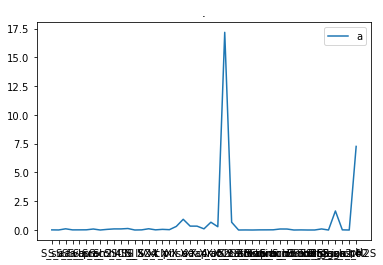

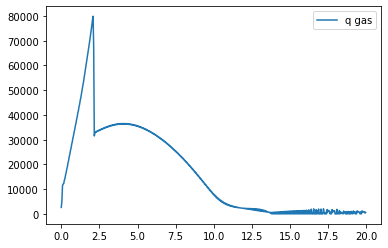

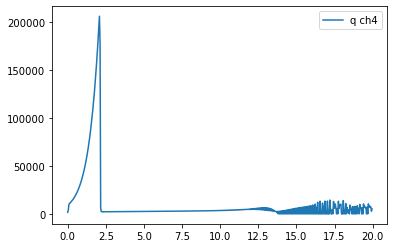

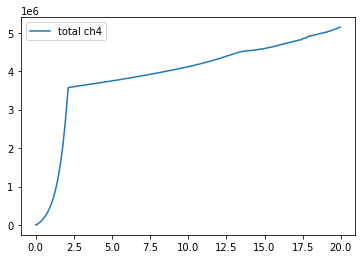

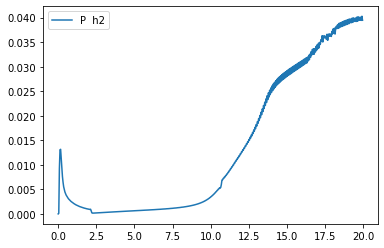

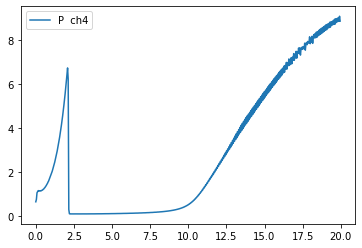

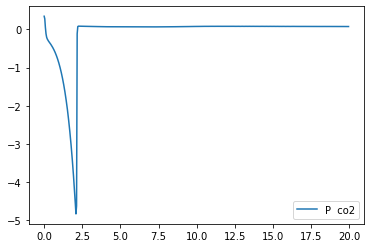

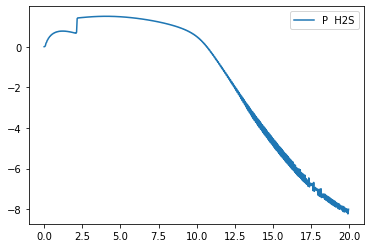

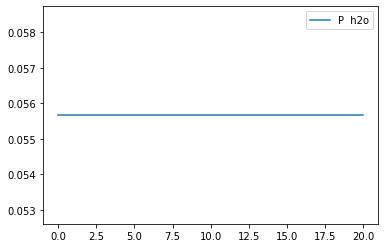

In [197]:
#cProfile.run('dyn_sim()')
a, b, t = dyn_sim()
gasflow_advanced = b

plt.figure()
plt.title(f'.')
plt.plot(a.iloc[1], label = 'a')
plt.legend()


for i in b.keys():
    plt.figure()
    print(i)
    plt.plot(t[0:-1], b.loc[:,i], label = i)
#plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
#plt.xlabel("temprature [K]")
    plt.legend()

print(b.keys())
#b.reset_index()
#b.set_index(t[0:-1])
#b.head()

In [10]:
def method_test(i):
    t_step = np.linspace(0, 10, i)
    a = set_initial_states()
    solvermethod = 'DOP853' 
    for p in range(i):
        simulate(t_step, solvermethod, a)

In [15]:
t = 0.001
#cProfile.run('dyn_sim()')


cProfile.run('method_test(5)')

         464 function calls (452 primitive calls) in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(linspace)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(ndim)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(result_type)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1017(_handle_fromlist)
        1    0.000    0.000    0.001    0.001 <ipython-input-10-12d77467389f>:1(method_test)
        1    0.000    0.000    0.000    0.000 <ipython-input-3-4917bc0c1cb9>:1(set_initial_states)
        1    0.000    0.000    0.000    0.000 <ipython-input-4-eb3331738976>:2(ADM1_ODE)
        1    0.000    0.000    0.000    0.000 <ipython-input-5-d5360b8e03dd>:2(simulate)
        1  

NameError: name 'S_su_in' is not defined